In [ ]:
#%pip install -r requirements.txt

**Note**: This demo is adapted from the LXMERT Demo present here: https://github.com/huggingface/transformers/tree/master/examples/research_projects/lxmert

In [1]:
from IPython.display import Image, display
import PIL.Image
import io
import torch
import numpy as np
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils
from transformers import VisualBertForQuestionAnswering, BertTokenizerFast

# URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt"


# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# load object, attribute, and answer labels

objids = utils.get_data(OBJ_URL)
attrids = utils.get_data(ATTR_URL)
vqa_answers = utils.get_data(VQA_URL)

In [15]:
# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
visualbert_vqa = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at C:\Users\s194253/.cache\torch\transformers\57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


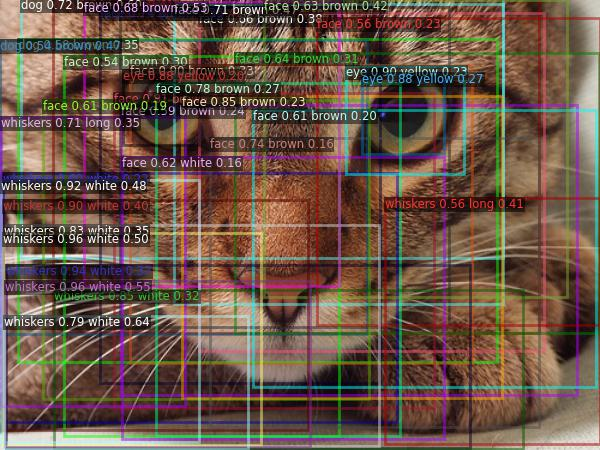

In [18]:
URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
URL = 'https://github.com/peteanderson80/bottom-up-attention/blob/master/data/demo/000542.jpg?raw=true'

# image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)
# run frcnn
images, sizes, scales_yx = image_preprocess(URL)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)
# add boxes and labels to the image

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [13]:
test_questions_for_url = [
     "Where is this scene?",
     "what is the man riding?",
     "What is the man wearing?",
     "What is the color of the horse?"
]
# test_questions_for_url = [
#    "Where is the cat?",
#    "What is near the disk?",
#    "What is the color of the table?",
#    "What is the color of the cat?",
#    "What is the shape of the monitor?",
# ]

# Very important that the boxes are normalized
# normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [14]:
for test_question in test_questions_for_url:
    test_question = [test_question]

    inputs = bert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    output_vqa = visualbert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_embeds=features,
        visual_attention_mask=torch.ones(features.shape[:-1]),
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["logits"].argmax(-1)
    print("\nQuestion:", test_question)
    print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])


Question: ['Where is this scene?']
prediction from VisualBert VQA: outside

Question: ['what is the man riding?']
prediction from VisualBert VQA: nothing

Question: ['What is the man wearing?']
prediction from VisualBert VQA: shirt

Question: ['What is the color of the horse?']
prediction from VisualBert VQA: brown
